# Softmax Exercise

The following elements have been implemented from scratch, without using starter code provided in cs231n/classifiers/ - 

- implemented a fully-vectorized **loss function** for the Softmax classifier
- implemented the fully-vectorized expression for its **analytic gradient**
- **gradient check** with numerical gradient
- **tuned the learning rate and regularization** strength
- **optimized** the loss function with **SGD**
- **visualized** the final learned weights

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
import time
import math
from __future__ import print_function
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Softmax Classifier Class

In [8]:
class softmax(object):
    
    def __init__(self, X, y, W, reg = 0.0):
        self.X = X
        self.y = y
        self.W = W
        self.reg = reg
        
    def lossgrad_naive(self, X, y, W, reg = 0.0):
        dW = np.zeros(W.shape)
        loss_naive = 0.0
        
        for i in range(X.shape[0]):
            f = X[i].dot(W)
            f -= np.max(f)
            expf = np.exp(f)
            loss_naive += - np.log(expf[y[i]]/np.sum(expf))
            
            for j in range(len(f)):
                if j != y[i]:
                    dW[:,j] += X[i,:]*expf[j]/np.sum(expf)
                elif j == y[i]:
                    dW[:,j] += X[i,:]*(-1 + expf[y[i]]/np.sum(expf))
                
        return loss_naive/X.shape[0] + reg*np.linalg.norm(W), dW/X.shape[0] + 2*reg*W
    
    def lossgrad_vectorized(self, X, y, W, reg = 0.0):
        dW = np.zeros(W.shape)
        loss_naive = 0.0
        z = np.arange(X.shape[0])
        
        f = X.dot(W)
        f = f - np.broadcast_to(np.reshape(np.max(f, axis=1), (f.shape[0],1)), (f.shape[0], f.shape[1]))
        expf = np.exp(f)
        
        expfy = np.reshape(expf[z,y], (X.shape[0],1))
        sum_exp = np.reshape(np.sum(expf, axis = 1), (X.shape[0],1))
        
        loss_naive = - np.sum(np.log((expfy/sum_exp)))
        
        norm_expf = expf/sum_exp
        norm_expf[z,y] -= 1
        
        dW = np.dot(X.T, norm_expf)

        return loss_naive/X.shape[0] + reg*np.linalg.norm(W), dW/X.shape[0] + 2*reg*W
    
    def sample_batch(self,X, y, batch_size = 32):
        idx = np.random.randint(X.shape[0], size = batch_size)
    
        return X[idx,:], y[idx]
    
    def train_SGD(self, X, y, learning_rate = 1e-7, reg = 0.0, num_iters = 1000, batch_size = 32):
        
        W = np.random.randn(X.shape[1], 10)*0.0001
        
        loss_list = []
        #loss, grad = lossgrad_vectorized(W, X, y, reg)
        for i in range(num_iters):
                  X_batch, y_batch = self.sample_batch(X, y, batch_size)
                  
                  loss, grad = self.lossgrad_vectorized(X, y, W, reg)
                  loss_list.append(loss)
                  W += - learning_rate * grad
        
        loss_final, grad = self.lossgrad_vectorized(X, y, W,reg)
        
        loss_list.append(loss_final)
        return loss_list, W
    


In [3]:
######################## OBTAINING DATA ##########################
cifar_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar_dir)

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

#Validation Set
X_val = X_train[range(num_training, num_training+num_validation)]
y_val = y_train[range(num_training, num_training+num_validation)]

#Training Set
X_train = X_train[range(num_training)]
y_train = y_train[range(num_training)]

#Development Set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

#Testing Set
X_test = X_test[range(num_test)]
y_test = y_test[range(num_test)]

X_train = np.reshape(X_train, (X_train.shape[0],-1))
X_test = np.reshape(X_test, (X_test.shape[0],-1))
X_val = np.reshape(X_val, (X_val.shape[0],-1))
X_dev = np.reshape(X_dev, (X_dev.shape[0],-1))

In [4]:
########################### NORMALIZING DATA ##########################
mean_image = np.mean(X_train, axis=0)

X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
X_dev -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0],1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0],1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0],1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0],1))])

In [5]:
W = np.random.randn(3073, 10)*0.0001

sm = softmax(X_dev, y_dev, W, 0.0)
loss, grad = sm.lossgrad_naive(X_dev, y_dev, W, 5e1)

print("Loss : ", loss)
print("Sanity Check : ", (-math.log(0.1)))

from cs231n.gradient_check import grad_check_sparse
f = lambda w: sm.lossgrad_naive(X_dev, y_dev, w, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Loss :  3.23737709966
Sanity Check :  2.30258509299
Relative Error :  0.0422212650114
Relative Error :  0.0500454086523
Relative Error :  0.0189692996007
Relative Error :  0.136319640055
Relative Error :  0.317393236053
Relative Error :  0.0209439343518
Relative Error :  0.880515368999
Relative Error :  0.0154824063472
Relative Error :  0.120636059665
Relative Error :  1.0


In [6]:
sm = softmax(X_dev, y_dev, W, 0.0)
loss2, grad2 = sm.lossgrad_naive(X_dev, y_dev, W, 5e2)
loss, grad = sm.lossgrad_vectorized(X_dev, y_dev,W, 5e2)

print(loss2, loss)
print(np.linalg.norm(grad2-grad))

11.1163374825 11.1163374825
1.64152571114e-13


## Hyperparameter Tuning

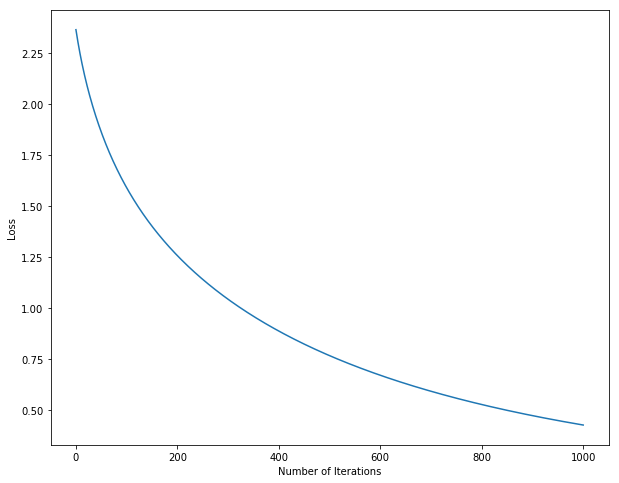

1e-07 1000.0 Time taken to train :  28.2189998627
13348
1e-07 5000.0 Time taken to train :  28.3559999466
13584
1e-07 10000.0 Time taken to train :  28.0400002003
13451
1e-07 50000.0 Time taken to train :  28.2860000134
13834
1e-07 1000000.0 Time taken to train :  28.128000021
12295
1e-07 5000000.0 Time taken to train :  28.0650000572
12033
5e-06 1000.0 Time taken to train :  28.1370000839
18297
5e-06 5000.0 Time taken to train :  27.9859998226
15768
5e-06 10000.0 Time taken to train :  28.3289999962
12756
5e-06 50000.0 Time taken to train :  28.2289998531
5239


C:\Users\shrey\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log


5e-06 1000000.0 Time taken to train :  30.5099999905
5650
5e-06 5000000.0 Time taken to train :  30.2630000114
5863
1e-06 1000.0 Time taken to train :  28.1969997883
18155
1e-06 5000.0 Time taken to train :  28.2249999046
17922
1e-06 10000.0 Time taken to train :  28.492000103
17407
1e-06 50000.0 Time taken to train :  28.1940000057
15067
1e-06 1000000.0 Time taken to train :  28.3299999237
2742
1e-06 5000000.0 Time taken to train :  30.0900001526
3149
5e-05 1000.0 Time taken to train :  28.4030001163
7853
5e-05 5000.0 Time taken to train :  28.0789999962
5216
5e-05 10000.0 Time taken to train :  28.481000185
3172
5e-05 50000.0 Time taken to train :  30.3499999046
2278
5e-05 1000000.0 Time taken to train :  29.748000145
4206
5e-05 5000000.0 Time taken to train :  30.2200000286
4656
1e-05 1000.0 Time taken to train :  28.4290001392
12893
1e-05 5000.0 Time taken to train :  28.2940001488
12356
1e-05 10000.0 Time taken to train :  28.5260000229
10414
1e-05 50000.0 Time taken to train :  2

C:\Users\shrey\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: overflow encountered in exp
C:\Users\shrey\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: overflow encountered in multiply


0.0005 5000000.0 Time taken to train :  30.0210001469
4913
0.0001 1000.0 Time taken to train :  28.1940000057
6529
0.0001 5000.0 Time taken to train :  29.1879999638
3175
0.0001 10000.0 Time taken to train :  36.4829998016
2869
0.0001 50000.0 Time taken to train :  30.3469998837
2097
0.0001 1000000.0 Time taken to train :  30.0740001202
3714
0.0001 5000000.0 Time taken to train :  30.4819998741
5862
For LR, reg  (1e-07, 1000.0) val, train accuracies are  (0.27800000000000002, 0.27240816326530615)
For LR, reg  (1e-07, 5000.0) val, train accuracies are  (0.29699999999999999, 0.27722448979591835)
For LR, reg  (1e-07, 10000.0) val, train accuracies are  (0.26100000000000001, 0.27451020408163268)
For LR, reg  (1e-07, 50000.0) val, train accuracies are  (0.28799999999999998, 0.28232653061224489)
For LR, reg  (1e-07, 1000000.0) val, train accuracies are  (0.26000000000000001, 0.25091836734693879)
For LR, reg  (1e-07, 5000000.0) val, train accuracies are  (0.26100000000000001, 0.24557142857142

In [17]:
############################### HYPERPARAMETER TUNING ###############################

sm = softmax(X_dev, y_dev, W, 0.0)
loss_list, W_final = sm.train_SGD(X_dev, y_dev)

plt.plot(loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

results = {}
best_acc = -1
best_sm = None

learning_rates = [1e-7, 5e-6, 1e-6, 5e-5, 1e-5, 5e-4, 1e-4]
regularization = [1e3, 5e3, 1e4, 5e4, 1e6, 5e6]

for i in range(len(learning_rates)):
    for j in range(len(regularization)):
        start = time.time()
        loss_list, W = sm.train_SGD(X_train, y_train, learning_rates[i], regularization[j], 100, 32)
        end = time.time()
        print(learning_rates[i], regularization[j], "Time taken to train : ", end - start)
        y_pred_train = np.argmax(X_train.dot(W), axis=1)
        y_pred_val = np.argmax(X_val.dot(W), axis=1)
        
        print(np.sum(y_pred_train == y_train))
        train_acc = (np.sum(y_pred_train == y_train).astype('float')/y_train.shape[0])
        val_acc = (np.sum(y_pred_val == y_val).astype('float')/y_val.shape[0])
        
        results[(learning_rates[i], regularization[j])] = (val_acc, train_acc)
        if(val_acc > best_acc):
            best_acc = val_acc

for i in sorted(results):
    print("For LR, reg ", i, "val, train accuracies are ", results[i])


0.374
(1e-06, 1000.0)


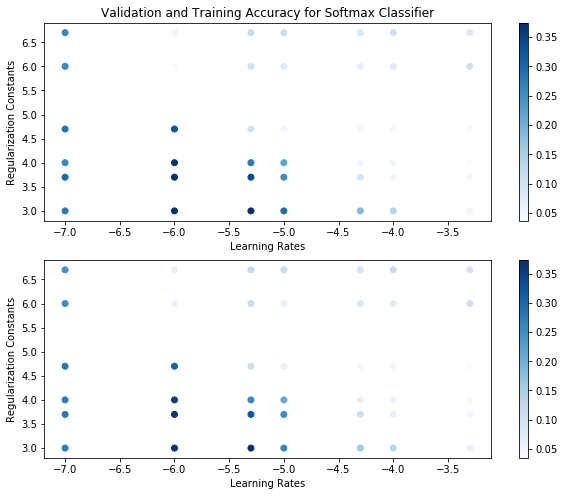

In [24]:
print(best_acc)
best_val = max(results, key=results.get)
print(best_val)

import math
import matplotlib.cm as cm

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

colors = [results[x][0] for x in results]

plt.subplot(2,1,1)
plt.scatter(x_scatter, y_scatter, c=colors, cmap = cm.Blues)
plt.xlabel("Learning Rates")
plt.ylabel("Regularization Constants")
plt.title("Validation and Training Accuracy for Softmax Classifier")
plt.colorbar()

colors2 = [results[x][1] for x in results]

plt.subplot(2,1,2)
plt.scatter(x_scatter, y_scatter, c=colors2, cmap=cm.Blues)
plt.xlabel("Learning Rates")
plt.ylabel("Regularization Constants")
plt.colorbar()
plt.show()

In [25]:
loss_list_final, W_final = sm.train_SGD(X_train, y_train, best_val[0], best_val[1], 1000, 32)

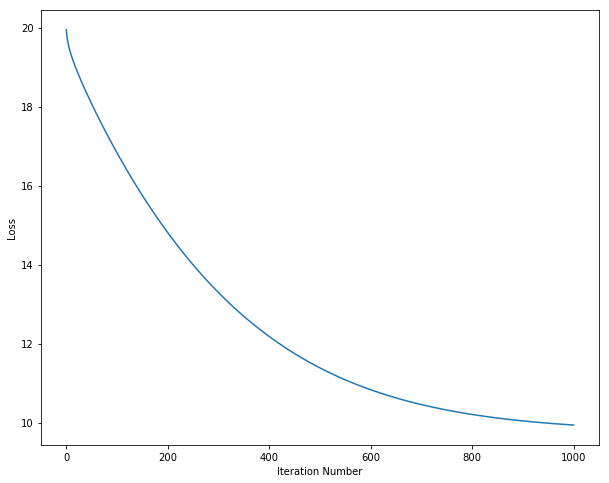

Final Accuracy :  0.391


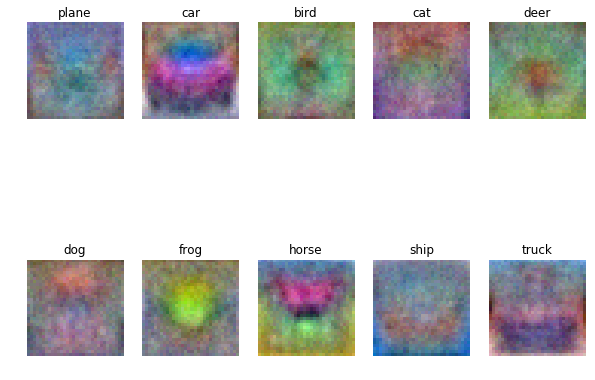

In [32]:
plt.plot(loss_list_final)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.show()

y_pred_test = np.argmax(X_test.dot(W_final), axis=1)

print("Final Accuracy : ", np.sum(y_pred_test == y_test).astype('float')/y_test.shape[0])

w = W_final[:-1,:]

w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])